In [1]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
import os
import SimpleITK as sitk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from image_utils import convert_series_to_nifti, quantize_maps
import json
import registration_gui as rgui
import logging
import shutil
import random
import re
from image_utils import ImageVisualizer, show_progress
DATASET_NUM = "040"
FOLD_NUM = 0

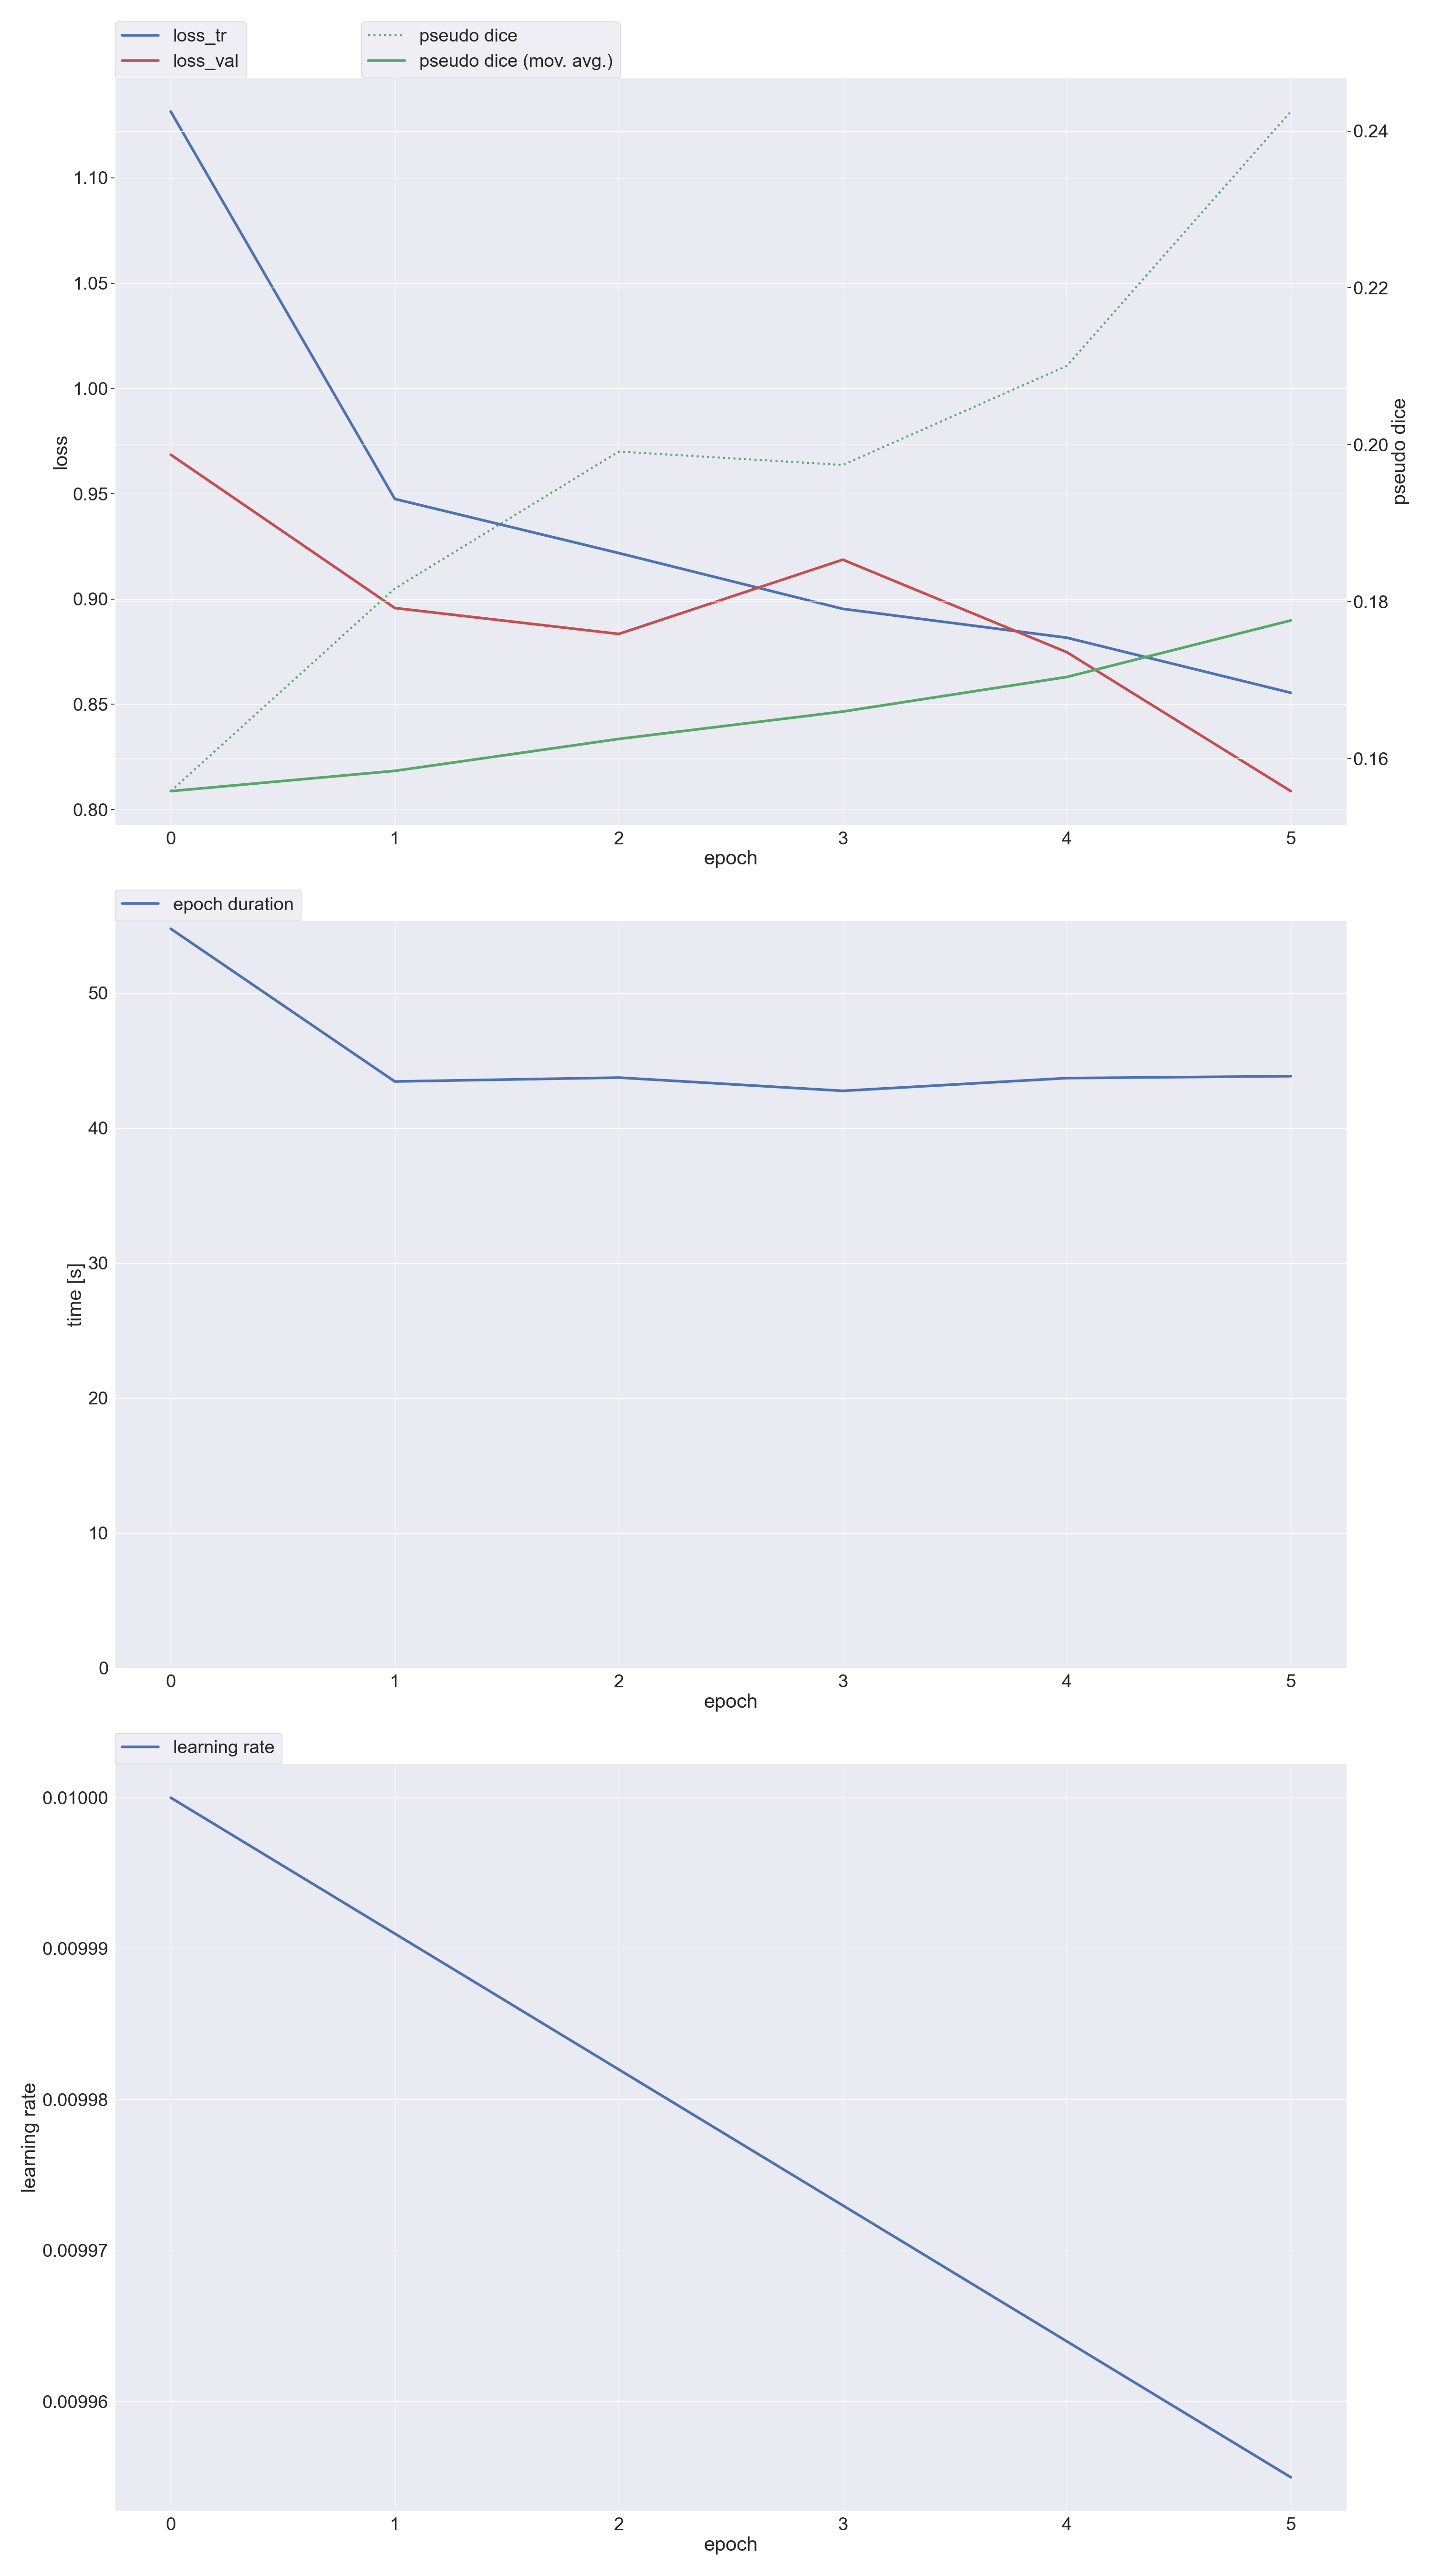

In [2]:
show_progress(fr"D:\nnUNet_results\Dataset{DATASET_NUM}_Perfusion\nnUNetTrainer__nnUNetPlans__3d_fullres\fold_{FOLD_NUM}\progress.png")

In [ ]:
input_folder = r'D:\CTH_archive\CTH_NIFTI'
stripped_folder = r'D:\CTH_archive\CTH_STRIPPED_MASK'
output_folder = r'D:\CTH_archive\CTH_STRIPPED'

# Ensure the stripped and output directories exist
os.makedirs(stripped_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

# Skull stripping process
for filename in os.listdir(input_folder):
    if filename.endswith(('.nii')):
        patient_name = filename.split(' ')[0]  # Extract patient name
        input_path = os.path.join(input_folder, filename)
        stripped_path = os.path.join(stripped_folder, patient_name)

        # Check if the stripped file already exists
        if not os.path.exists(stripped_path):
            try:
                input_img = nib.load(input_path)
                totalsegmentator(input_img, stripped_path, roi_subset=['brain'], ml=True)
                print(f"Processed and saved: {stripped_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")
        else:
            print(f"Stripped file already exists, skipping: {stripped_path}")

# Applying masks to stripped images
file_counter = 0  # Initialize file counter
missing_files = []

for mask_filename in tqdm(os.listdir(stripped_folder)):
    base_filename = os.path.splitext(mask_filename)[0].rsplit('.', 1)[0]  # Handle potential double extensions
    original_path = None

    # Find matching original file
    for original_filename in os.listdir(input_folder):
        if os.path.splitext(original_filename)[0].rsplit('.', 1)[0] == base_filename:
            original_path = os.path.join(input_folder, original_filename)
            break

    if original_path:
        mask_path = os.path.join(stripped_folder, mask_filename)
        #output_filename = base_filename + f"_{file_counter:03d}_0000.nii.gz"
        output_filename = base_filename
        output_path = os.path.join(output_folder, output_filename)

        # Check if the output file already exists
        if not os.path.exists(output_path):
            print(f"Applying mask to {original_path} using {mask_path}")

            # Load and apply mask
            mask_nii = nib.load(mask_path)
            original_nii = nib.load(original_path)
            masked_data = np.where(mask_nii.get_fdata() > 0, original_nii.get_fdata(), 0)
            masked_nii = nib.Nifti1Image(masked_data, affine=original_nii.affine)

            nib.save(masked_nii, output_path)
            file_counter += 1
        else:
            print(f"Masked file already exists, skipping: {output_path}")
    else:
        print(f"No matching file found for {mask_filename} in {input_folder}")
        missing_files.append((mask_filename, input_folder))

print("Mask application complete.")
if missing_files:
    print("Missing files:", missing_files)


In [ ]:
transforms_dir = "D:/CTH_archive/TRANSFORMS"
fixed_images_dir = "D:/CTH_archive/CTH_STRIPPED"  
moving_images_dir = "D:/CTH_archive/CTP_STRIPPED" 

def register_images(fixed_image_path, moving_image_path, transforms_dir):
    # Extract patient identifier from the file name, ensuring .nii is not included
    patient = os.path.splitext(os.path.basename(moving_image_path))[0]
    patient = os.path.splitext(patient)[0]  # Remove .nii if present

    # Construct the transform file path
    transform_file = os.path.join(transforms_dir, f'{patient}.h5')

    # Check if the transform file already exists and skip registration if it does
    if os.path.exists(transform_file):
        print(f"Transform file already exists for patient {patient}, skipping registration.")
        return

    # Load the fixed and moving images
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)

    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingPercentage(0.10)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=200)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Initialize the transform
    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image, moving_image.GetPixelID()), 
                                                          moving_image, 
                                                          sitk.AffineTransform(fixed_image.GetDimension()),
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    registration_method.SetInitialTransform(initial_transform, True)

    try:
        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        
        # Save the transform
        sitk.WriteTransform(final_transform, transform_file)
        sitk.WriteImage(sitk.Resample(moving_image, fixed_image, final_transform,  sitk.sitkNearestNeighbor), f"D:/CTH_archive/CTP_STRIPPED_REG/{patient}.nii")
        print("Final metric value: {0}".format(registration_method.GetMetricValue()))
        print(
            "Optimizer's stopping condition, {0}".format(
                registration_method.GetOptimizerStopConditionDescription()
            )
        )
        print(f"Registration successful for patient: {patient}. Transform saved to {transform_file}")
    except RuntimeError as e:
        print(f"Registration failed for patient {patient}: {e}")


for filename in tqdm(os.listdir(fixed_images_dir)):
    fixed_image_path = os.path.join(fixed_images_dir, filename)
    moving_image_path = os.path.join(moving_images_dir, filename)

    if os.path.isfile(fixed_image_path) and os.path.isfile(moving_image_path):
        register_images(fixed_image_path, moving_image_path, transforms_dir)


In [ ]:
FINAL_SIZE = 512

def resample_image(moving_image, ctp_image):
    desired_size = [FINAL_SIZE, FINAL_SIZE, ctp_image.GetSize()[2]] # Use the same number of slices as the CTP image
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving_image)
    resampler.SetSize(desired_size)
    resampler.SetOutputSpacing([moving_image.GetSpacing()[i] * (moving_image.GetSize()[i] / desired_size[i]) for i in range(3)]) 
    resampler.SetInterpolator(sitk.sitkLinear)
    resized_moving_image = resampler.Execute(moving_image)
    resized_moving_image.SetSpacing(ctp_image.GetSpacing())
    resized_moving_image.SetOrigin(ctp_image.GetOrigin())
    resized_moving_image.SetDirection(ctp_image.GetDirection())
    return resized_moving_image

def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    final_transform = sitk.ReadTransform(transform_file_path)
    resampled_image = sitk.Resample(resized_moving_image, 
                                    fixed_image, 
                                    final_transform, 
                                    sitk.sitkNearestNeighbor, 
                                    0.0, 
                                    fixed_image.GetPixelID())
    return resampled_image

def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    try:
        final_transform = sitk.ReadTransform(transform_file_path)
        
        # Ensure the resized_moving_image is valid before proceeding
        if resized_moving_image:
            resampled_image = sitk.Resample(resized_moving_image, 
                                            fixed_image, 
                                            final_transform, 
                                            sitk.sitkLinear, 
                                            0.0, 
                                            fixed_image.GetPixelID())
            return resampled_image
        else:
            logging.error("Resized moving image is invalid. Cannot apply final transform.")
            return None
    except Exception as e:
        logging.error("Failed to apply final transform: " + str(e))
        return None

tmax_nifti_dir = r"D:/CTH_archive/TMAX_NIFTI"
transforms_dir = r"D:/CTH_archive/TRANSFORMS"
cth_stripped_dir = r"D:/CTH_archive/CTH_STRIPPED"
ctp_stripped_dir = r"D:/CTH_archive/CTP_STRIPPED"
output_dir = r'D:/CTH_archive/TMAX_REGISTERED'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Iterate over the transformation files
for transform_file in os.listdir(transforms_dir):
    transform_path = os.path.join(transforms_dir, transform_file)
    base_filename = transform_file.replace('.h5', '')

    # Paths to the moving, fixed, and reference (ctp) images
    moving_image_path = os.path.join(tmax_nifti_dir, base_filename + '.nii')
    fixed_image_path = os.path.join(cth_stripped_dir, base_filename + '.nii')
    ctp_image_path = os.path.join(ctp_stripped_dir, base_filename + '.nii')
    print(f"Processing {base_filename}...")

    # Check if all required files exist
    if os.path.exists(moving_image_path) and os.path.exists(fixed_image_path) and os.path.exists(ctp_image_path):
        # Load images
        moving_image = sitk.ReadImage(moving_image_path)
        fixed_image = sitk.ReadImage(fixed_image_path)
        ctp_image = sitk.ReadImage(ctp_image_path)

        # Resample the moving image
        resized_moving_image = resample_image(moving_image, ctp_image)

        # Apply the final transformation
        resampled_image = apply_final_transform(resized_moving_image, fixed_image, transform_path)

        # Save the resampled image
        resampled_image_path = os.path.join(output_dir, base_filename + '.nii')
        sitk.WriteImage(resampled_image, resampled_image_path)
        print(f"Processed and saved: {resampled_image_path}")
    else:
        print(f"Required files for {base_filename} are not available.")
    

In [ ]:
TMAX_SOURCE_DIR = r'D:\\CTH_archive\\TMAX_REGISTERED\\'
TMAX_QUNTIZED_DIR = r'D:\\CTH_archive\\TMAX_NIFTI_QUANT_REGISTERED'

quantization_levels = 5

quantize_maps(TMAX_SOURCE_DIR, TMAX_QUNTIZED_DIR, quantization_levels=quantization_levels)

In [ ]:
num_test_files = 5

def convert_and_copy_with_labels_and_rename(image_source_dir, image_target_dir, label_source_dir, label_target_dir, images_test_dir, labels_test_dir):
    # Ensure all target directories exist, create if they don't
    for dir_path in [image_target_dir, label_target_dir, images_test_dir, labels_test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    # List all .nii files in the source directory
    all_files = [f for f in sorted(os.listdir(image_source_dir)) if f.endswith('.nii')]
    
    # Determine the number of files to sample, ensuring it's not more than the total number of files available
    num_test_files = min(5, len(all_files))

    # Randomly select files for testing, based on the determined number
    test_files = random.sample(all_files, num_test_files)

    counter = 0

    # Move selected test files and their labels
    for file_name in tqdm(test_files, desc="Moving test files"):
        # Extract base name without extension and trailing numbers
        base_name = re.match(r"(.*?)(?:_\d+)?(?=\.\w+$)", file_name).group(1)
        
        # Increment the counter
        counter += 1

        # Construct new file names with suffixes
        new_image_name = f"{base_name}_{counter:03d}_0000.nii.gz"
        new_label_name = f"{base_name}_{counter:03d}.nii.gz"
        
        # Copy the image file with the new name
        shutil.copy(os.path.join(image_source_dir, file_name), os.path.join(images_test_dir, new_image_name))
        
        # Adjust the file name for the label to match the source
        label_file_name = file_name.replace('.nii.gz', '.nii') if file_name.endswith('.nii.gz') else file_name
        
        # Copy the label file with the new name
        shutil.copy(os.path.join(label_source_dir, label_file_name), os.path.join(labels_test_dir, new_label_name))
        
        print(f"Moved {file_name} and its label to the test directories with new names: {new_image_name} and {new_label_name}")

    # Remove test files from the all_files list
    for test_file in test_files:
        all_files.remove(test_file)

    # Initialize a counter for unique naming within the training set
    counter = 0

    # Iterate over the remaining files for training
    for file_name in tqdm(all_files, desc="Processing training files"):
        # Construct full source file paths for images and labels
        image_source_file_path = os.path.join(image_source_dir, file_name)
        label_source_file_path = os.path.join(label_source_dir, file_name)

        # Load the .nii file (image)
        nii_image = nib.load(image_source_file_path)

        # Construct the new file name for images and labels
        base_name = file_name[:-4]  # Remove .nii extension
        new_image_name = f"{base_name}_{counter:03d}_0000.nii.gz"
        new_label_name = f"{base_name}_{counter:03d}.nii.gz"

        # Construct target file paths
        image_target_file_path = os.path.join(image_target_dir, new_image_name)
        label_target_file_path = os.path.join(label_target_dir, new_label_name)

        # Save the image file as .nii.gz in the target directory
        nib.save(nii_image, image_target_file_path)
        print(f"Converted and copied image: {image_source_file_path} to {image_target_file_path}")

        # Load the .nii file (label)
        nii_label = nib.load(label_source_file_path)

        # Save the label file as .nii.gz in the target directory
        nib.save(nii_label, label_target_file_path)
        print(f"Converted and copied label: {label_source_file_path} to {label_target_file_path}")

        # Increment the counter for unique naming
        counter += 1

# Define source and target directories for images and labels
image_source_dir = rf"D:/CTH_archive/CTH_STRIPPED"
image_target_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/imagesTr"
label_source_dir = rf"D:/CTH_archive/TMAX_NIFTI_QUANT_REGISTERED"
label_target_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/labelsTr"

# Define target directories for testing
images_test_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/imagesTs"
labels_test_dir = rf"D:/nnUNet_raw/Dataset{DATASET_NUM}_Perfusion/labelsTs"

convert_and_copy_with_labels_and_rename(image_source_dir, image_target_dir, label_source_dir, label_target_dir, images_test_dir, labels_test_dir)



In [ ]:
def generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", num_test_data=0):
    """
    Generate a dataset.json file for the given dataset with dynamic quantization levels.

    Args:
    - dataset_dir (str): Directory where the dataset files are stored.
    - num_quant_levels (int): Number of quantization levels (excluding the background).
    - channel_names (dict): Mapping of channel indices to their names.
    - file_ending (str): File extension of the dataset files.
    - num_test_data (int): The number of the dataset to be used for testing.

    Returns:
    - None
    """
    # Dynamically generate labels based on the number of quantization levels
    labels = {"background": "0"}
    for i in range(1, num_quant_levels + 1):
        labels[f"quantized_{i}"] = str(i)

    # Count the number of dataset files
    num_training = len([file for file in os.listdir(dataset_dir) if file.endswith(file_ending)])

    # Use the specified number of test data and calculate the remaining number of training files
    num_test = num_test_data

    # Construct the dataset JSON structure
    dataset_json = {
        "labels": labels,
        "numTraining": num_training,
        "numTest": num_test,
        "channel_names": channel_names,
        "file_ending": file_ending
    }

    # Write the JSON structure to a file
    with open(os.path.join(nnUNet_dir, "dataset.json"), 'w') as json_file:
        json.dump(dataset_json, json_file, indent=4)

    print(f"dataset.json file has been generated in {nnUNet_dir}")

# Example usage
dataset_dir = rf'D:\nnUNet_raw\Dataset{DATASET_NUM}_Perfusion\labelsTr'  # Path to dataset directory
nnUNet_dir = rf'D:\nnUNet_raw\Dataset{DATASET_NUM}_Perfusion'  # Path to nnUNet directory
num_quant_levels = 5  # Number of quantization levels (excluding background)
channel_names = {"0": "CT"}
num_test_data = 5  # Specify the number of test data

generate_dataset_json(dataset_dir, num_quant_levels, channel_names, nnUNet_dir, file_ending=".nii.gz", num_test_data=num_test_data)


In [ ]:
!nnuNetv2_plan_and_preprocess -d $DATASET_NUM --verify_dataset_integrity

In [ ]:
!nnUNetv2_train $DATASET_NUM 3d_fullres $FOLD_NUM --npz -device cuda

In [ ]:
!nnUNetv2_predict -d Dataset_{DATASET_NUM}_Perfusion -i  D:\nnUNet_raw\Dataset_{DATASET_NUM}Perfusion\imagesTs -o D:\nnUNet_output\Dataset{DATAST_NUM}Perfusion -f  0 -tr nnUNetTrainer -c 3d_fullres -p nnUNetPlans

In [ ]:
from image_utils import ImageVisualizer

prediction_dir = rf"D:\nnUnet_output\Dataset{DATASET_NUM}_Perfusion"
ground_truth_dir = rf"D:\nnUNet_raw\Dataset{DATASET_NUM}_Perfusion\labelsTs"
ct_images_dir = r"D:\CTH_archive\CTH_STRIPPED"

visualizer = ImageVisualizer(prediction_dir, ground_truth_dir, ct_images_dir)
visualizer.display()
